# daWUAP - Economic Modeling with PMP

**Author:** K. Arthur Endsley and Marco Maneta  
**Date:** August 2020

This is just one of many daWUAP interactive demos. See also:

- [Hydrologic Modeling Demo](https://www.umt.edu/hydro-econ-ag/crop-water/demo_hydrology.html)
- [Economic Modeling with Positive Mathematical Programming (PMP)](https://www.umt.edu/hydro-econ-ag/crop-water/demo_econ_pmp.html)
- [Economic Modeling with Stochastic Data Assimilation](https://www.umt.edu/hydro-econ-ag/crop-water/demo_econ_stochastic.html)

## Introduction

This notebook demonstrates how to use daWUAP to calibrate and run an economic model of water- and land-constrained agricultural production using **positive mathematical programming (PMP).** This is one of two options for calibrating and running scenarios of agricultural production with daWUAP, the other option being stochastic data assimilation. This demonstration covers:

- How to **calibrate the economic model using positive mathematical programming (PMP)** based on prior observation data;
- How to **create a Scenario data dictionary** describing constraints and market conditions;
- How to **run a Scenario,** for example, **where water available for farming is reduced by 20%.**

**Table of Contents**

1. [**Setup**](#Setup)
1. [**Model Calibration with PMP**](#Model-Calibration-with-PMP)
  1. [Requirements](#Requirements)
  1. [Calibration with PMP](#Calibration-with-PMP)
1. [**Running a Scenario**](#Running-a-Scenario)
  1. [Generating Scenario Data](#Generating-Scenario-Data)
  1. [Simulating Baseline Conditions](#Simulating-Baseline-Conditions)
1. [**Scenario: 20% Reduction in ET**](#Scenario:-20%-Reduction-in-ET)

## Setup

In [1]:
%pylab inline
import numpy as np

Populating the interactive namespace from numpy and matplotlib


## Model Calibration with PMP

The first step in running the economic module is calibration against observed land and water allocations made by farmers, for each crop type.

### Requirements

For model calibration, we need:

- **Farm Definitions JSON file:** A JSON dictionary, `Farms.json`, which describes what farms are present, the crops they grow... It has one key, "farms", which is a list of the farms. Each farm has a number of attributes. The farm `id` links the farm to its polygon feature in the Farms Location GeoJSON file. Later, the model will ask for what field in the GeoJSON file corresponds to the farmers/ water users: the `water_user_id` field. The `source_id` is the node in the river network from which that farm draws water. The `parameters` and `simulated_states` are initially set to zero--these are what are going to be estimated by the hydro-economic model.
- **Observations JSON file:** A JSON dictionary describing the costs per unit area or unit volume of land and water for each crop type in each year for which we want to calibrate. In the stochastic approach, a running mean across the years is calculated. In the PMP approach, only one year of data is used; this might be a representative year or a synthetic year, using observations from multiple different (actual) years.

Each of these JSON files contains one or more data dictionaries describing the characteristics of a farm or observations of water and land allocations at a farm.

*These files have been provided for this demo.* When calibrating and running scenarios for your own region of interest, you can use the functions in `daWUAP.utils.fixtures` to generate data dictionary templates for Farms, Observations, and Scenarios.

In [2]:
from daWUAP.econengine import Farm
import json
import numpy as np
    
# Open farmers file
with open('./economic_inputs/Farms.json', 'r') as stream:
    original_farms = json.load(stream)
    
# Open observed activity files for a given year
with open('./observations/observations2012.json') as stream:
    observations = json.load(stream)

### Calibration with PMP

Calibration is done separately for each farm, so we use a `for` loop to iterate through the farms, find the observations data dictionary matching that farm, and calibrating that farm.

In [3]:
# We're going to calibrate the model separately for each farm
calibrated_farms = {'farms': list()}

for record in original_farms['farms']:
    print("Calibrating farm", record['name'])
    farm = Farm(**record)
    
    # Find the observation record with this Farm's id
    farm_obs = list(filter(lambda r: r['id'] == farm.id, observations)).pop()
    
    # Optionally set the maximum number of iterations
    farm_obs['options'] = {'maxiter': 100000} 
    
    # Calibrate the farm using PMP
    result = farm.calibrate(**farm_obs)
    if result.success:
        calibrated_farms['farms'].append(farm.write_farm_dict())
        
# Save calibrated farms
with open('./calibrated_Farms.json', 'w') as stream:
     json.dump(calibrated_farms, stream)

Calibrating farm Deer Lodge
Farm Deer Lodge with id 30023 successfully calibrated
Calibrating farm Granite
Farm Granite with id 30039 successfully calibrated
Calibrating farm Lewis And Clark
Farm Lewis And Clark with id 30049 successfully calibrated
Calibrating farm Mineral
Farm Mineral with id 30061 successfully calibrated
Calibrating farm Missoula
Farm Missoula with id 30063 successfully calibrated
Calibrating farm Powell
Farm Powell with id 30077 successfully calibrated
Calibrating farm Ravalli
Farm Ravalli with id 30081 successfully calibrated
Calibrating farm Silver Bow
Farm Silver Bow with id 30093 successfully calibrated


**We now have a JSON file with the calibrated farms, describing the empirical relationships regarding farmer decisions learned in the economic model.** This can be used to simulate farmer decisions under different scenarios. To verify that we have a good calibration, we can simulate farmer decisions under the same (observed) conditions we used for calibration: **a so-called "baseline conditions" simulation.** This should lead to simulated land and water allocations that very closely match the observed allocations.

## Running a Scenario

The `Scenarios.json` file describes the climatic, economic, and policy conditions that prevail during the scenario we want to run. The keys of the `Scenarios.json` file have similar meanings to those in the observations JSON file but prescribe different values according to the desired scenario.

- `mean_costs` quantify the cost of cultivating land and water per crop type per unit area (dollars/ hectare) or volume (dollars/ mm-hectare).
- `crop_start_date`, `crop_cover_date`, and `crop_end_date` specify the growing season for that crop. Crop phenology is modeled as increasing from start to `crop_cover_date`, at which the crop experiences peak growth (i.e., covers the field), and decreasing from there to end. The phenology of a crop is modeled internally based on this information and a crop-specific coefficient term.
- `mean_evapotranspiration` is the evapotranspiration in the absence of irrigation (meteoric sources of water only).
- `mean_land_constraint` is the amount of land available for cropping actually available to the farmer, not including fallow or other unused land. For example, if a farmer rotates 100 ha every 3 years, you could specify the `mean_land_constraint` as ~66 ha (1/3 of 100 ha).
- `mean_water_constraint` is the amount of water available (mm-hectares), with -1 indicating an unlimited amount of water. This could be a physical limit (i.e., amount of water that can be drawn from a stream) or a policy limit.
- `mean_prices` are the prices that farmers believe they will receive per unit weight of crop, for each crop type.

**A "scenario" could also be based on real observations (baseline conditions):** the values could be identical to those in the observations JSON file. In such a case, the model would reproduce what the farmers actually did.

### Generating Scenario Data

The `daWUAP.utils.fixtures` module contains convenience functions like `generate_scenario()` which will create a template Scenario data dictionary we can use as a starting point for running a scenario. We'd have to update this dictionary with real data values. **Because we're interested in running a baseline scenario, it's appropriate to use `generate_scenario2()`, which accepts a Farm and an Observations data dictionary to populate a real Scenario data dictionary based on past observations.**

In [10]:
from daWUAP.utils.fixtures import generate_scenario2
    
# Get the number of unique crop types
num_crop_types = len(calibrated_farms['farms'][0]['crop_list'])

year = 2012
scenarios = []
farm_ids = [f['id'] for f in calibrated_farms['farms']]
for each_id in farm_ids:
    the_farm = list(filter(lambda r: r['id'] == each_id, calibrated_farms['farms'])).pop()
    the_obs = list(filter(lambda r: r['id'] == each_id, observations)).pop()
    # Get a Scenario template based on the farm characteristics and prior observations
    scenario_data = generate_scenario2(num_crop_types, the_farm, the_obs, year)
    # The template Scenario data dict. doesn't have the right dates yet
    scenario_data.update({
        'crop_start_date': ['5/15/%d' % year for i in range(0, num_crop_types)],
        'crop_cover_date': ['7/02/%d' % year for i in range(0, num_crop_types)],
        'crop_end_date': ['8/25/%d' % year for i in range(0, num_crop_types)],
    })
    scenarios.append(scenario_data)
    
# Save baseline scenarios
with open('./Scenarios.json', 'w') as stream:
     json.dump(scenarios, stream)

### Simulating Baseline Conditions

**Now, we're ready to simulate baseline conditions.** Each `Farm` instance has a `simulate()` method, which uses PMP for simulation by default.

In [11]:
# Simulate baseline conditions
simulated_farms = {'farms': []}

all_results = []
for farm_data in calibrated_farms['farms']:
    farm = Farm(**farm_data)
    farm_scenario = [
        s for s in scenarios if s['farm_id'] == farm_data['id']
    ]
    result = farm.simulate(**farm_scenario[0])
    all_results.append(result)
    if result.success:
        simulated_farms['farms'].append(farm.write_farm_dict())

**Again, one reason for the baseline simulation is to verify that we have a good calibration.** Looking at the farm with ID 30093, we can compare it's observed land allocations per crop type...

In [12]:
example_observation = list(filter(lambda r: r['id'] == '30093', observations)).pop()
np.array(example_observation['mean_obs_land']).round(1)

array([397.8, 437. ,  12.2,  23.9,   4.4,   7.5,   1.5])

...With the simulated land allocations per crop type:

In [13]:
example_simulation = list(filter(lambda r: r['id'] == '30093', simulated_farms['farms'])).pop()
np.array(example_simulation['simulated_states']['used_land']).round(1)

array([393.2, 436.3,  12. ,  23.9,   4.3,   7.5,   1.5])

**The simulated land allocations are a good match for the observations!** We can also make a plot to verify the goodness-of-fit between observed and simulated land allocations.

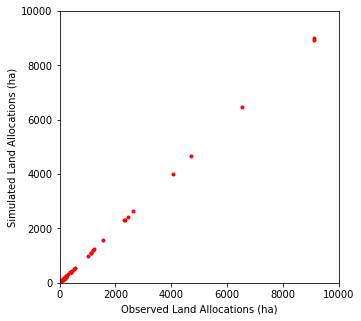

In [7]:
from matplotlib import pyplot

# We have observations for more farms than we calibrated on, so filter to the calibrated farms only
farm_ids = [f['id'] for f in calibrated_farms['farms']]

obs = sorted([
    (str(f['id']), f['mean_obs_land']) 
    for f in observations if str(f['id']) in farm_ids
], key = lambda x: x[0]) 
sims = sorted([
    (f['id'], f['simulated_states']['used_land']) for f in simulated_farms['farms']
], key = lambda x: x[0])

# Once the data are sorted by farm ID, pair observations, simulations for same farm
plot_data = list(zip([x[1] for x in obs], [x[1] for x in sims]))

pyplot.figure(figsize = (5, 5))
pyplot.plot([x[1] for x in obs], [x[1] for x in sims], 'r.')
pyplot.xlim(0, 10e3)
pyplot.ylim(0, 10e3)
pyplot.xlabel('Observed Land Allocations (ha)')
pyplot.ylabel('Simulated Land Allocations (ha)')
pyplot.show()

## Scenario: 20% Reduction in ET

Evapotranspiration (ET) is like a currency plants spend to grow. We can simulate a reduction in water from natural (meteoric or groundwater) sources by reducing evapotranspiration. In such a scenario, we can see that farmers generally reduce the area planted for all crop types, with greater reductions among the non-irrigated crop types.

In [14]:
with open('./Scenarios.json', 'r') as stream:
     scenarios = json.load(stream)
        
# Reduce ET in each scenario by 20%
for each_scenario in scenarios:
    each_scenario['mean_evapotranspiration'] = np.multiply(each_scenario['mean_evapotranspiration'], 0.8).tolist()

In [15]:
# Simulate baseline conditions
simulated_farms2 = {'farms': []}

all_results = []
for farm_data in calibrated_farms['farms']:
    farm = Farm(**farm_data)
    farm_scenario = [
        s for s in scenarios if s['farm_id'] == farm_data['id'] 
    ]
    # Again, we can add options to the optimization if we so choose
    # farm_scenario[0]['options'] = {'maxiter': 100000}
    result = farm.simulate(**farm_scenario[0])
    all_results.append(result)
    if result.success:
        simulated_farms2['farms'].append(farm.write_farm_dict())

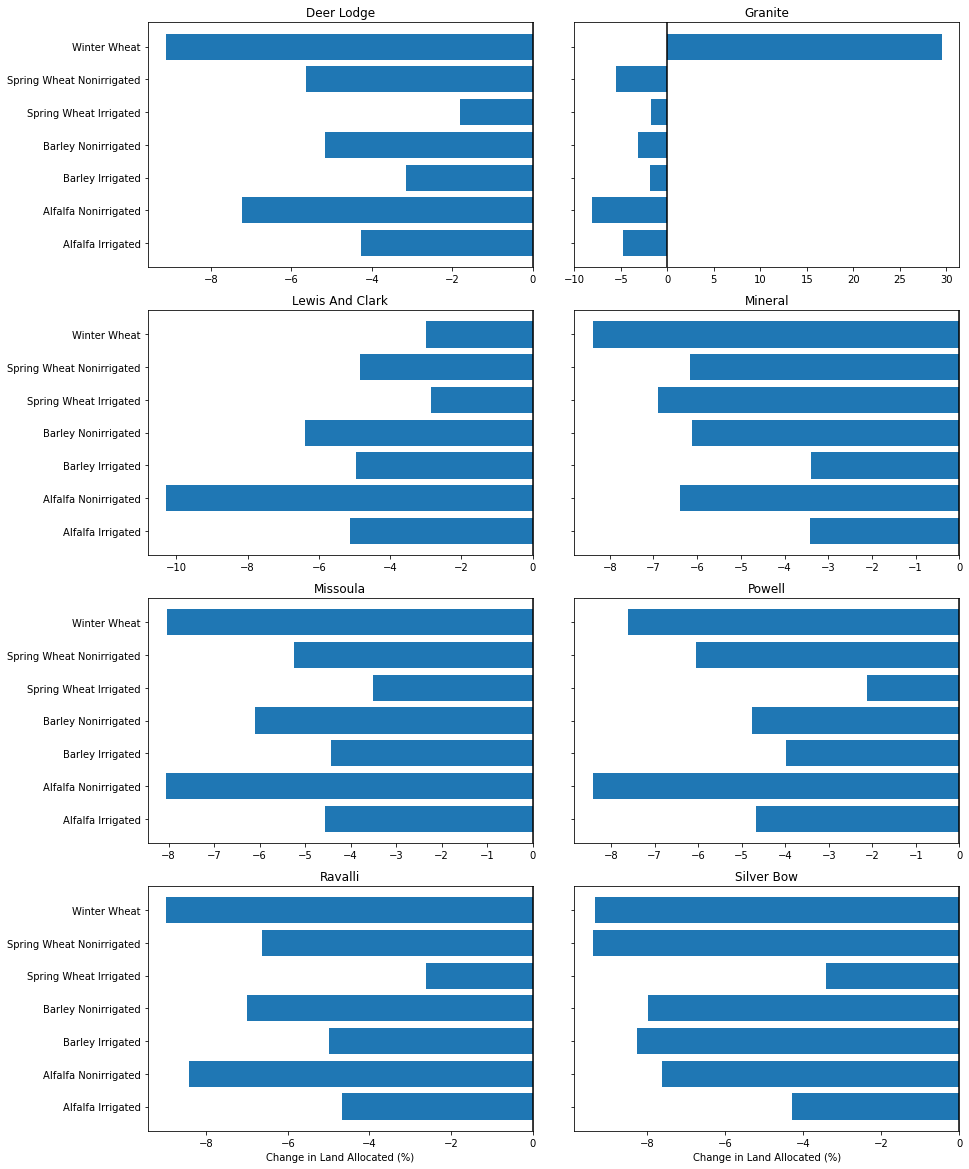

In [16]:
from matplotlib import pyplot

crops = simulated_farms2['farms'][0]['crop_list']

idx = 0
fig, axes = pyplot.subplots(nrows = 4, ncols = 2, figsize = (12, 12))
fig.tight_layout()
for i, row in enumerate(axes):
    for j, col in enumerate(row):
        farm_sim = simulated_farms2['farms'][idx]
        farm_obs = list(filter(lambda r: r['id'] == farm_sim['id'], observations)).pop()
        pct_change = 100 * (
            np.array(farm_sim['simulated_states']['used_land']) - np.array(farm_obs['mean_obs_land'])) / np.array(farm_obs['mean_obs_land'])
        col.barh(np.arange(0, len(crops)), pct_change)
        col.axvline(x = 0, color = 'black')
        col.set_title(farm_sim['name'])
        col.set_xlabel('Change in Land Allocated (%)' if i == 3 else '')
        col.set_yticks(np.arange(0, len(crops)))
        col.set_yticklabels(crops if j == 0 else ('' for _ in crops))
        idx += 1
        
fig.subplots_adjust(bottom = -0.3)
pyplot.show()